In [0]:
%matplotlib inline

In [79]:
from google.colab import files
upload = files.upload()
upload = files.upload()

Saving sudokuD.png to sudokuD.png


In [37]:
!apt install tesseract-ocr
!apt install libtesseract-dev
!pip install pyocr
!curl -L https://github.com/tesseract-ocr/tessdata/raw/master/jpn.traineddata > jpn.traineddata
!cp jpn.traineddata /usr/share/tesseract-ocr/tessdata

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   145  100   145    0     0   1124      0 --:--:-- --:--:-- --:--:--  1124
100 34.0M  100 34.0M    0     0  11.2M      0  0:00:03  0:00:03 --:--:-- 14.5M


In [38]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import sys
import pyocr
import pyocr.builders
from PIL import Image, ImageDraw, ImageFont

#ここから下はOCRが使えるかの確認なのだが、これらがないとtoolが機能しなくなるのでもし完成させるとしたらprintを外して対応

#OCRが使用可能かをチェック
tools = pyocr.get_available_tools()
if len(tools) == 0:
    print("OCR tool is not found")
    sys.exit(1)

#OCRツール名を表示
tool = tools[0]
print("OCR tool is '%s'" % (tool.get_name()))

#OCR対応言語を表示
langs = tool.get_available_languages()
print("Available languages: %s" % ", ".join(langs))
lang = langs[0]
print("Will use lang '%s'" % (lang))

OCR tool is 'Tesseract (sh)'
Available languages: eng, osd
Will use lang 'eng'


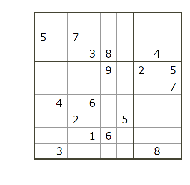

width:  367
height: 362


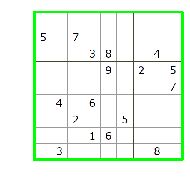

img21:5
img23:7
img34:3
img35:8
img38:4
img45:9
img47:2
img49:5
img59:7
img62:4
img64:6
img73:2
img76:5
img84:1
img85:6
img92:3
img98:8
This is the problem!
...|...|...
5.7|...|...
...|38.|.4.
-------------------
...|.9.|2.5
...|...|..7
.4.|6..|...
-------------------
..2|..5|...
...|16.|...
.3.|...|.8.

This is the answer!
493|526|871
587|941|623
126|387|549
-------------------
368|794|215
259|813|467
741|652|938
-------------------
812|435|796
974|168|352
635|279|184

sucess!


In [57]:
#全部を関数化させてみる
#そのテストのために使ったが少し改良を加えたいのでテストしている

def predict_image():
  #img = cv2.imread(name)
  h, w, _ = img.shape
  print('width: ', w)
  print('height:', h)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (3, 3), 0)
  im2 = cv2.threshold(gray, 140, 225, cv2.THRESH_BINARY_INV)[1]

  cnts = cv2.findContours(im2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]

  dot = [0, 0, 0, 0, 0]

  for pt in cnts:
    X, Y, W, H = cv2.boundingRect(pt)
    cv2.rectangle(img, (X, Y), (X+W, Y+H), (0, 255, 0), 5)
    sqware = (W)*(H)
    if sqware > dot[0]:
      dot.clear()
      dot.extend([sqware, X, Y, W, H]) 
    
  plt.subplot(1, 2, 2)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()
    
  return (dot)


def resize_image(dot, area):
  imgC = img[dot[2]+area:dot[2]+dot[4]-area, dot[1]+area:dot[1]+dot[3]-area]
  imgDATA = cv2.resize(imgC, (900, 900))
  return (imgDATA)

def optical_recognition(imgDATA, contours, recogsize):
  sudokudata = []

  for y in range(9):
    for x in range(9):
      coordinate = (str(y + 1) + str(x + 1))

      contoursY1 = y * 100
      contoursY2 = contoursY1 + 100
      contoursX1 = x * 100
      contoursX2 = contoursX1 + 100

      filename = "img" + coordinate


      image = imgDATA[contoursY1 + 5 + contours:contoursY2 + 5 - contours,
                      contoursX1 + 2 + contours:contoursX2 + 2 - contours]


      #二値化
      image = cv2.threshold(image,180,255,cv2.THRESH_BINARY)[1]

      #判定に入る
      sizeX = (50-int(recogsize))/2
      sizeY = sizeX + int(recogsize)
      checkimg = image[int(sizeX):int(sizeY), int(sizeX):int(sizeY)]
      checkimg = checkimg.flatten()
      if 0 not in checkimg:
        sudokudata.append(0)
      else:
        #print("number")
        #まだ完成形ではないため、数字をpngで出力して余白を追加させる
        cv2.imwrite("{}.png".format(filename), image)

        newimg = Image.open("{}.png".format(filename))
        imgwhite = Image.open('white50.png')
        imgwhite.paste(newimg, (25, 25))
        imgwhite.save("{}a.png".format(filename), quality=95)

        txt = tool.image_to_string(
            Image.open("{}a.png".format(filename)),
            lang="eng",
            builder=pyocr.builders.TextBuilder(tesseract_layout=6))
        
        print("{}:{}".format(filename, txt))
        sudokudata.append(int(txt))
        
        
  values = encode(str(sudokudata))
  return (values)
        
#Pythonで数独

def encode(grid):
    "テキストから２次元配列のvaluesを作成する"
    values = []
    digits = "123456789"
    chars = [c for c in grid if c in digits or c in '0.']
    assert len(chars) == 81
    grid_int = map(lambda x: int(x) if x != "." else 0, chars)

    count = 0
    row = []
    for i in grid_int:
        row.append(i)
        count += 1
        if count % 9 == 0: #行毎に分割
            values.append(row)
            row = []
    return values

def main(data):
  if solve(0, 0, data):
    #printtable(data)
    return data
  else:
    print ("This problem is unsolvable")

def solve(x, y, table):
  if x == 0 and y == 9:
    return True

  if table[y][x] == 0:
    for t in range(1, 10):
      table[y][x] = t
      if check(x, y, table):
        (nx, ny) = next(x, y)
        if solve(nx, ny, table):
          return True
    table[y][x] = 0
    return False
  else:
    (nx, ny) = next(x, y)
    if solve(nx, ny, table):
      return True

def next(x, y):
  x += 1
  if x > 8:
    x = 0
    y += 1
  return (x, y)

def check(x, y, table):
  return row(x, y, table) and column(x, y, table) and block(x, y, table)

def column(x, y, table):
  for yt in range(9):
    if yt != y:
      if table[y][x] == table[yt][x]:
        return False
  return True

def row(x, y, table):
  for xt in range(9):
    if xt != x:
      if table[y][x] == table[y][xt]:
        return False
  return True

def block(x, y, table):
  xbase = (x // 3) * 3
  ybase = (y // 3) * 3
  for yt in range(ybase, ybase + 3):
    for xt in range(xbase, xbase + 3):
      if xt != x and yt != y:
        if table[y][x] == table[yt][xt]:
          return False
  return True

def printtable(table):
  for y in range(9):
    for x in range(9):
      print (table[y][x])
    print ("")

def output(data):
    for i in range(9):
        for j in range (9):
            if data[i][j] == 0:
                print (".", end="")
            else:
                print (data[i][j], end="")

            if (j+1) % 3 == 0 and j < 8:
                print ("|", end="")
        print("")
        if (i+1) % 3 == 0 and i < 8:
            print ("-------------------")
    print("")

    
#入力するもの一覧
name = "sudoku2.PNG" #画像の名前
area = 5 #枠抽出から外を引くパラメーター
contours = 12 #一つ一つの数字画像の周りをくりぬくパラメーター
recogsize = 30 #数字か空白か判定する際の枠(50*50の画像で中心からの大きさ)


img = cv2.imread(name)
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
dot = predict_image()
imgDATA = resize_image(dot, area)
values = optical_recognition(imgDATA, contours, recogsize)


print("This is the problem!")
output(values)
main(values)
print("This is the answer!")
output(values)

print("sucess!")

In [58]:
#引き渡しなどをすべて調整し終えて関数化完成！

def predict_image(area, contours, recogsize):
  #img = cv2.imread(name)
  h, w, _ = img.shape
  print('width: ', w)
  print('height:', h)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (3, 3), 0)
  im2 = cv2.threshold(gray, 140, 225, cv2.THRESH_BINARY_INV)[1]

  cnts = cv2.findContours(im2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]

  dot = [0, 0, 0, 0, 0]

  for pt in cnts:
    X, Y, W, H = cv2.boundingRect(pt)
    cv2.rectangle(img, (X, Y), (X+W, Y+H), (0, 255, 0), 30)
    sqware = (W)*(H)
    if sqware > dot[0]:
      dot.clear()
      dot.extend([sqware, X, Y, W, H]) 
      
  values = resize_image(area, contours, recogsize, dot)
  return (values)


def resize_image(area, contours, recogsize, dot):
  imgC = img[dot[2]+area:dot[2]+dot[4]-area, dot[1]+area:dot[1]+dot[3]-area]
  imgDATA = cv2.resize(imgC, (900, 900))
  values = optical_recognition(area, contours, recogsize, dot, imgDATA)
  return (values)

def optical_recognition(area, contours, recogsize, dot, imgDATA):
  sudokudata = []

  for y in range(9):
    for x in range(9):
      coordinate = (str(y + 1) + str(x + 1))

      contoursY1 = y * 100
      contoursY2 = contoursY1 + 100
      contoursX1 = x * 100
      contoursX2 = contoursX1 + 100

      filename = "img" + coordinate


      image = imgDATA[contoursY1 + 5 + contours:contoursY2 + 5 - contours,
                      contoursX1 + 2 + contours:contoursX2 + 2 - contours]


      #二値化
      image = cv2.threshold(image,180,255,cv2.THRESH_BINARY)[1]

      #判定に入る
      sizeX = (50-int(recogsize))/2
      sizeY = sizeX + int(recogsize)
      checkimg = image[int(sizeX):int(sizeY), int(sizeX):int(sizeY)]
      checkimg = checkimg.flatten()
      if 0 not in checkimg:
        sudokudata.append(0)
      else:
        #print("number")
        #まだ完成形ではないため、数字をpngで出力して余白を追加させる
        cv2.imwrite("{}.png".format(filename), image)

        newimg = Image.open("{}.png".format(filename))
        imgwhite = Image.open('white50.png')
        imgwhite.paste(newimg, (25, 25))
        imgwhite.save("{}a.png".format(filename), quality=95)

        txt = tool.image_to_string(
            Image.open("{}a.png".format(filename)),
            lang="eng",
            builder=pyocr.builders.TextBuilder(tesseract_layout=6))

        sudokudata.append(int(txt))
        
  values = encode(str(sudokudata))
  return (values)
        
#Pythonで数独

def encode(grid):
    "テキストから２次元配列のvaluesを作成する"
    values = []
    digits = "123456789"
    chars = [c for c in grid if c in digits or c in '0.']
    assert len(chars) == 81
    grid_int = map(lambda x: int(x) if x != "." else 0, chars)

    count = 0
    row = []
    for i in grid_int:
        row.append(i)
        count += 1
        if count % 9 == 0: #行毎に分割
            values.append(row)
            row = []
    return values

def main(data):
  if solve(0, 0, data):
    #printtable(data)
    return data
  else:
    print ("This problem is unsolvable")

def solve(x, y, table):
  if x == 0 and y == 9:
    return True

  if table[y][x] == 0:
    for t in range(1, 10):
      table[y][x] = t
      if check(x, y, table):
        (nx, ny) = next(x, y)
        if solve(nx, ny, table):
          return True
    table[y][x] = 0
    return False
  else:
    (nx, ny) = next(x, y)
    if solve(nx, ny, table):
      return True

def next(x, y):
  x += 1
  if x > 8:
    x = 0
    y += 1
  return (x, y)

def check(x, y, table):
  return row(x, y, table) and column(x, y, table) and block(x, y, table)

def column(x, y, table):
  for yt in range(9):
    if yt != y:
      if table[y][x] == table[yt][x]:
        return False
  return True

def row(x, y, table):
  for xt in range(9):
    if xt != x:
      if table[y][x] == table[y][xt]:
        return False
  return True

def block(x, y, table):
  xbase = (x // 3) * 3
  ybase = (y // 3) * 3
  for yt in range(ybase, ybase + 3):
    for xt in range(xbase, xbase + 3):
      if xt != x and yt != y:
        if table[y][x] == table[yt][xt]:
          return False
  return True

def printtable(table):
  for y in range(9):
    for x in range(9):
      print (table[y][x])
    print ("")

def output(data):
    for i in range(9):
        for j in range (9):
            if data[i][j] == 0:
                print (".", end="")
            else:
                print (data[i][j], end="")

            if (j+1) % 3 == 0 and j < 8:
                print ("|", end="")
        print("")
        if (i+1) % 3 == 0 and i < 8:
            print ("-------------------")
    print("")

    
#調整するパラメーター一覧
name = "sudoku.png" #画像の名前
area = 20 #枠抽出から外を引くパラメーター
contours = 12 #一つ一つの数字画像の周りをくりぬくパラメーター
recogsize = 30 #数字か空白か判定する際の枠(50*50の画像で中心からの大きさ)


img = cv2.imread(name)
values = predict_image(area, contours, recogsize)
print("This is the problem!")
output(values)
main(values)
print("This is the answer!")
output(values)

print("sucess!")

width:  1236
height: 1242
This is the problem!
..3|2..|8..
.2.|.19|..7
9..|...|.2.
-------------------
..5|1..|6..
.9.|.65|..3
..7|9..|4..
-------------------
..8|5..|9..
5..|...|.6.
.7.|.93|..1

This is the answer!
713|254|896
824|619|357
956|387|124
-------------------
385|142|679
491|765|283
267|938|415
-------------------
148|576|932
539|421|768
672|893|541

sucess!


In [88]:
#どんな画像でもエラーが出ないようにする関数を開発中

def predict_image(contours, recogsize):
  #img = cv2.imread(name)
  h, w, _ = img.shape
  print('width: ', round(w, -2))
  print("height: ", round(h, -2))
  area = round(0.02 * round(min(h, w), -2) - 3) #ここのパラメーター超重要
  width = round(0.03 * round(min(h, w), -2) - 6) #ここのパラメーター超重要
  if area > 20: area = 20
  if width > 30: width = 30
  print("area: ", area)
  print("width: ", width)
  
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (3, 3), 0)
  im2 = cv2.threshold(gray, 140, 225, cv2.THRESH_BINARY_INV)[1]

  cnts = cv2.findContours(im2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]

  dot = [0, 0, 0, 0, 0]

  for pt in cnts:
    X, Y, W, H = cv2.boundingRect(pt)
    cv2.rectangle(img, (X, Y), (X+W, Y+H), (0, 255, 0), width)
    sqware = (W)*(H)
    if sqware > dot[0]:
      dot.clear()
      dot.extend([sqware, X, Y, W, H]) 
  print(dot[3], dot[4])    
  values = resize_image(area, contours, recogsize, dot)
  return (values)


def resize_image(area, contours, recogsize, dot):
  imgC = img[dot[2]+area:dot[2]+dot[4]-area, dot[1]+area:dot[1]+dot[3]-area]
  imgDATA = cv2.resize(imgC, (900, 900))
  values = optical_recognition(area, contours, recogsize, dot, imgDATA)
  return (values)

def optical_recognition(area, contours, recogsize, dot, imgDATA):
  sudokudata = []

  for y in range(9):
    for x in range(9):
      coordinate = (str(y + 1) + str(x + 1))

      contoursY1 = y * 100
      contoursY2 = contoursY1 + 100
      contoursX1 = x * 100
      contoursX2 = contoursX1 + 100

      filename = "img" + coordinate


      image = imgDATA[contoursY1 + 5 + contours:contoursY2 + 5 - contours,
                      contoursX1 + 2 + contours:contoursX2 + 2 - contours]


      #二値化
      image = cv2.threshold(image,180,255,cv2.THRESH_BINARY)[1]

      #判定に入る
      sizeX = (50-int(recogsize))/2
      sizeY = sizeX + int(recogsize)
      checkimg = image[int(sizeX):int(sizeY), int(sizeX):int(sizeY)]
      checkimg = checkimg.flatten()
      if 0 not in checkimg:
        sudokudata.append(0)
      else:
        #print("number")
        #まだ完成形ではないため、数字をpngで出力して余白を追加させる
        cv2.imwrite("{}.png".format(filename), image)

        newimg = Image.open("{}.png".format(filename))
        imgwhite = Image.open('white50.png')
        imgwhite.paste(newimg, (25, 25))
        imgwhite.save("{}a.png".format(filename), quality=95)

        txt = tool.image_to_string(
            Image.open("{}a.png".format(filename)),
            lang="eng",
            builder=pyocr.builders.TextBuilder(tesseract_layout=6))

        print("{}:{}".format(filename, txt))
        sudokudata.append(int(txt))
        
  values = encode(str(sudokudata))
  return (values)
        
#Pythonで数独

def encode(grid):
    "テキストから２次元配列のvaluesを作成する"
    values = []
    digits = "123456789"
    chars = [c for c in grid if c in digits or c in '0.']
    assert len(chars) == 81
    grid_int = map(lambda x: int(x) if x != "." else 0, chars)

    count = 0
    row = []
    for i in grid_int:
        row.append(i)
        count += 1
        if count % 9 == 0: #行毎に分割
            values.append(row)
            row = []
    return values

def main(data):
  if solve(0, 0, data):
    #printtable(data)
    return data
  else:
    print ("This problem is unsolvable")

def solve(x, y, table):
  if x == 0 and y == 9:
    return True

  if table[y][x] == 0:
    for t in range(1, 10):
      table[y][x] = t
      if check(x, y, table):
        (nx, ny) = next(x, y)
        if solve(nx, ny, table):
          return True
    table[y][x] = 0
    return False
  else:
    (nx, ny) = next(x, y)
    if solve(nx, ny, table):
      return True

def next(x, y):
  x += 1
  if x > 8:
    x = 0
    y += 1
  return (x, y)

def check(x, y, table):
  return row(x, y, table) and column(x, y, table) and block(x, y, table)

def column(x, y, table):
  for yt in range(9):
    if yt != y:
      if table[y][x] == table[yt][x]:
        return False
  return True

def row(x, y, table):
  for xt in range(9):
    if xt != x:
      if table[y][x] == table[y][xt]:
        return False
  return True

def block(x, y, table):
  xbase = (x // 3) * 3
  ybase = (y // 3) * 3
  for yt in range(ybase, ybase + 3):
    for xt in range(xbase, xbase + 3):
      if xt != x and yt != y:
        if table[y][x] == table[yt][xt]:
          return False
  return True

def printtable(table):
  for y in range(9):
    for x in range(9):
      print (table[y][x])
    print ("")

def output(data):
    for i in range(9):
        for j in range (9):
            if data[i][j] == 0:
                print (".", end="")
            else:
                print (data[i][j], end="")

            if (j+1) % 3 == 0 and j < 8:
                print ("|", end="")
        print("")
        if (i+1) % 3 == 0 and i < 8:
            print ("-------------------")
    print("")

    
#調整するパラメーター一覧
name = "sudoku.png" #画像の名前
#area = 20 #枠抽出から外を引くパラメーター(手動でやっていたが自動化)
contours = 12 #一つ一つの数字画像の周りをくりぬくパラメーター
recogsize = 30 #数字か空白か判定する際の枠(50*50の画像で中心からの大きさ)


img = cv2.imread(name)
values = predict_image(contours, recogsize)
print("This is the problem!")
output(values)
main(values)
print("This is the answer!")
output(values)

print("sucess!")

width:  1200
height:  1200
area:  20
width:  30
1215 1216
img13:3
img14:2
img17:8
img22:2
img25:1
img26:9
img29:7
img31:9
img38:2
img43:5
img44:1
img47:6
img52:9
img55:6
img56:5
img59:3
img63:7
img64:9
img67:4
img73:8
img74:5
img77:9
img81:5
img88:6
img92:7
img95:9
img96:3
img99:1
This is the problem!
..3|2..|8..
.2.|.19|..7
9..|...|.2.
-------------------
..5|1..|6..
.9.|.65|..3
..7|9..|4..
-------------------
..8|5..|9..
5..|...|.6.
.7.|.93|..1

This is the answer!
713|254|896
824|619|357
956|387|124
-------------------
385|142|679
491|765|283
267|938|415
-------------------
148|576|932
539|421|768
672|893|541

sucess!


一応OK